# Home Credit EDA 

### Table of Contents
 * [Set up](#setup)
 * [Introduction](#intro)
 * [Description](#description)
     * [How many variables and observations?](#names_and_obs)
     * [What are the column names and descriptions?](#names)
 * [Missing Data Discussion](#md-discussion)
     * [How much of the data is missing?](#missing)
 * [Exploratory Vizualizations and Summary Tables](#evst)
     * [Loan Amounts Distribution](#loan_amounts_dist)
     * [Loan Amounts Distribution by Education](#loan_amounts_by_education)
     * [Count of Loan Purposes by Payment Difficulties](#loan_purpose_by_target)
     * [What does our data look like?](#look)
     * [What are the correlations of the different variables with the target?](#correlation)
 * [Adding Some Data](#add)
     * [What is the correlation with the added data?](#add_corr)
     * [What percentage of those with issues have had a previous loan?](#prev_loan)
 * [Results](#results)


## Set up <a class="anchor" id="setup"></a>

In [1]:
#Get the different packages that might be used
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
#!pip install opendatasets
import opendatasets as od

In [2]:
#Get the data #Make sure that your kaggle.json file is in the working directory
od.download("https://www.kaggle.com/competitions/home-credit-default-risk/data")

Skipping, found downloaded files in "./home-credit-default-risk" (use force=True to force download)


In [3]:
#Get the working directory for file extraction
current_working_directory = os.getcwd()

In [4]:
#Get the required datasets
test_data = pd.read_csv(current_working_directory + "/home-credit-default-risk/application_test.csv")
train_data = pd.read_csv(current_working_directory + "/home-credit-default-risk/application_train.csv")
previous_application_data = pd.read_csv(current_working_directory + "/home-credit-default-risk/previous_application.csv")

In [5]:
#Create full datasets for exploration
all_the_data = pd.concat([test_data, train_data], axis = 0)
main_data_joined_prevapp = all_the_data.merge(previous_application_data, on = "SK_ID_CURR", how = "left")

In [6]:
#See if they match
print(main_data_joined_prevapp.shape)
print(all_the_data.shape)

(1687612, 158)
(356255, 122)


In [7]:
#Change the viewing so we can see what is there easier.
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', None)

#To revert these changes
pd.reset_option('display.max_rows', None)
pd.reset_option('display.max_colwidth', None)

### Are there duplicate records after the merge of all data? <a class="anchor" id="duplicates"></a>

In [8]:
#Check for duplicate records in the main dataset and give a nice output to that question.
if all_the_data.duplicated(subset=["SK_ID_CURR"]).any() == False: #The code before the .any() looks at the column "SK_ID_CURR" and checks to see if there are any duplicates. This returns a column that is a boolean. The .any() is looking to see if any of those are True.
    print("There are no duplicates in the main dataset.")
else:
    print("There are duplicates in the main dataset.")

There are no duplicates in the main dataset.


In [9]:
#Check for duplicate records in the combined dataset and give a nice output to that question.
if main_data_joined_prevapp.duplicated(subset=["SK_ID_CURR"]).any() == False: #The code before the .any() looks at the column "SK_ID_CURR" and checks to see if there are any duplicates. This returns a column that is a boolean. The .any() is looking to see if any of those are True.
    print("There are no duplicates in the combined dataset.")
else:
    print("There are duplicates in the combined dataset.")

There are duplicates in the combined dataset.


## Introduction <a class="anchor" id="intro"></a>

Home Credit is interested in learning whether or not clients will run into "payment difficulties". Having this knowledge is in the best interest of both the client and the firm. With less people defaulting on their loans, there are more resources available to assist those that are in need of assistance. With better detection on payment difficulties, those that would run in to trouble are helped to not enter into debt that could be dehabilitating later.

## Description <a class="anchor" id="description"></a>

The data that has been provided from Home Credit has a target variable that conveniently is labeled as "target" in the dataset. This is a 1 if people are going to run into any payment difficulties and a zero for all other situations. There are 120 independant variables that are related to this target. One of the columns is reserved for the observation number.

### How many variables and observations? <a class="anchor" id="names_and_obs"></a>

In [10]:
all_the_data.shape

(356255, 122)

### What are the column names and descriptions? <a class="anchor" id="names"></a>

In [11]:
#Read in the file
column_names_and_descriptions = pd.read_csv(current_working_directory + "/home-credit-default-risk/HomeCredit_columns_description.csv", encoding = "ISO-8859-1")
#Just look at the files that we are currently using
column_names_and_descriptions[column_names_and_descriptions["Table"] == 'application_{train|test}.csv']

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
117,120,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
118,121,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
119,122,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN
120,123,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,NaN


## Missing Data Discussion <a class="anchor" id="md-discussion"></a>

Of the 120 independent variables, there are 66 that have missing variables. Of these 66, 17 of the variables are missing more than 60 percent of their data. As per a recommendation from Jeremy, these missing values are going to be replaced with zeros in order to not affect running of regressions in the future.

### How much of the data is missing? <a class="anchor" id="missing"></a>

In [12]:
#Sum all the nulls and divide by number of rows to get percentage
all_the_data_missing = pd.DataFrame(round(all_the_data.isnull().sum()/all_the_data.shape[0]*100,2))
#Name this output to assist in code below
all_the_data_missing.columns = ['missing']
#Check the dimensions
print(all_the_data_missing[all_the_data_missing.missing > 0].shape)
#View the sorted amount of missing values
all_the_data_missing[all_the_data_missing.missing > 0].sort_values('missing', ascending=False)

(66, 1)


,missing
COMMONAREA_MEDI,69.71
COMMONAREA_MODE,69.71
COMMONAREA_AVG,69.71
NONLIVINGAPARTMENTS_MEDI,69.29
NONLIVINGAPARTMENTS_MODE,69.29
...,...
OBS_60_CNT_SOCIAL_CIRCLE,0.29
DEF_60_CNT_SOCIAL_CIRCLE,0.29
EXT_SOURCE_2,0.19
AMT_GOODS_PRICE,0.08


### How many variables have missing data? <a class="anchor" id="missing2"></a>
    

In [13]:
#find the amount of variables that have missing data
print(len(all_the_data_missing[all_the_data_missing.missing > 0]),"of the variables are missing data.")

66 of the variables are missing data.


In [14]:
#find the amount of variables with missing data amounts above 60%.
print(len(all_the_data_missing[all_the_data_missing.missing > 60]),"of the 66 variables are missing more than 60% of their data.")

17 of the 66 variables are missing more than 60% of their data.


## Exploratory Vizualizations and Summary Tables <a class="anchor" id="evst"></a>

### Loan Amounts Distribution <a class="anchor" id="loan_amounts_dist"></a>

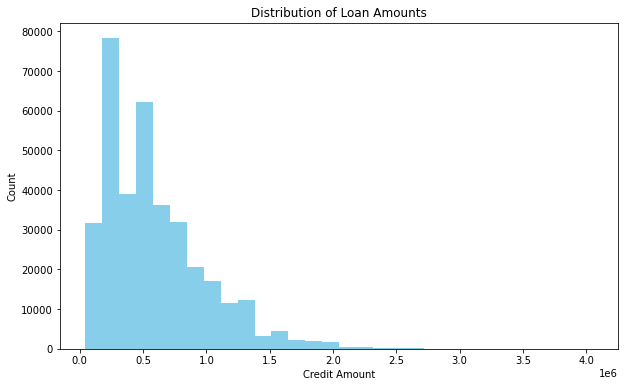

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(all_the_data['AMT_CREDIT'], bins=30, color='skyblue')
plt.xlabel('Credit Amount')
plt.ylabel('Count')
plt.title('Distribution of Loan Amounts')
plt.show()

### Loan Amounts Distribution by Education <a class="anchor" id="loan_amounts_by_education"></a>

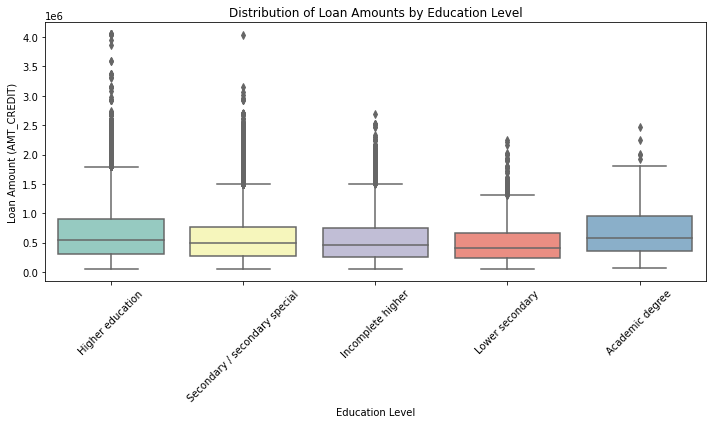

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=all_the_data, x='NAME_EDUCATION_TYPE', y='AMT_CREDIT', palette='Set3')
plt.xlabel('Education Level')
plt.ylabel('Loan Amount (AMT_CREDIT)')
plt.title('Distribution of Loan Amounts by Education Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Count of Loan Purposes by Payment Difficulties <a class="anchor" id="loan_purpose_by_target"></a>

<Figure size 720x432 with 0 Axes>

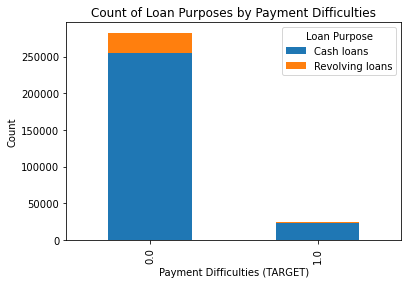

In [17]:
grouped_data = all_the_data.groupby(['TARGET', 'NAME_CONTRACT_TYPE']).size().unstack()

plt.figure(figsize=(10, 6))
grouped_data.plot(kind='bar', stacked=True)
plt.xlabel('Payment Difficulties (TARGET)')
plt.ylabel('Count')
plt.title('Count of Loan Purposes by Payment Difficulties')
plt.legend(title='Loan Purpose')
plt.show()

### What does our data look like? <a class="anchor" id="look"></a>

In [18]:
#Look at the summary stats. Rounding makes the numbers look nice. Transposing makes looking at the df a little more intuitive when looking for a variable.
round(all_the_data.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,356255.0,278128.00,102842.10,100001.0,189064.5,278128.0,367191.5,456255.0
CNT_CHILDREN,356255.0,0.41,0.72,0.0,0.0,0.0,1.0,20.0
AMT_INCOME_TOTAL,356255.0,170116.06,223506.82,25650.0,112500.0,153000.0,202500.0,117000000.0
AMT_CREDIT,356255.0,587767.41,398623.69,45000.0,270000.0,500211.0,797557.5,4050000.0
AMT_ANNUITY,356219.0,27425.56,14732.81,1615.5,16731.0,25078.5,34960.5,258025.5
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_WEEK,308687.0,0.03,0.19,0.0,0.0,0.0,0.0,8.0
AMT_REQ_CREDIT_BUREAU_MON,308687.0,0.23,0.86,0.0,0.0,0.0,0.0,27.0
AMT_REQ_CREDIT_BUREAU_QRT,308687.0,0.30,0.79,0.0,0.0,0.0,0.0,261.0
AMT_REQ_CREDIT_BUREAU_YEAR,308687.0,1.91,1.87,0.0,0.0,1.0,3.0,25.0


### What are the correlations of the different variables with the target? <a class="anchor" id="correlation"></a>

In [19]:
#Create the df of all the correlations
corr_df = pd.DataFrame(all_the_data.corr())
#Reduce the df to show only corr with the target
corr_df = pd.DataFrame(corr_df["TARGET"])
#Name the columns
corr_df.columns = ["Correlation w/ Target"]

In [20]:
#View the df
corr_df.sort_values("Correlation w/ Target")

,Correlation w/ Target
EXT_SOURCE_3,-0.178919
EXT_SOURCE_2,-0.160472
EXT_SOURCE_1,-0.155317
DAYS_EMPLOYED,-0.044932
FLOORSMAX_AVG,-0.044003
...,...
DAYS_LAST_PHONE_CHANGE,0.055218
REGION_RATING_CLIENT,0.058899
REGION_RATING_CLIENT_W_CITY,0.060893
DAYS_BIRTH,0.078239


## Adding Some Data <a class="anchor" id="add"></a>

In [24]:
#Look at the files that we are currently using
column_names_and_descriptions[column_names_and_descriptions["Table"] == 'previous_application.csv'][:10] #the last bit is for the requirement of avoiding long output

,Unnamed: 0,Table,Row,Description,Special
173,176,previous_application.csv,SK_ID_PREV,ID of previous credit in Home credit related t...,hashed
174,177,previous_application.csv,SK_ID_CURR,ID of loan in our sample,hashed
175,178,previous_application.csv,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loa...",NaN
176,179,previous_application.csv,AMT_ANNUITY,Annuity of previous application,NaN
177,180,previous_application.csv,AMT_APPLICATION,For how much credit did client ask on the prev...,NaN
178,181,previous_application.csv,AMT_CREDIT,Final credit amount on the previous applicatio...,NaN
179,182,previous_application.csv,AMT_DOWN_PAYMENT,Down payment on the previous application,NaN
180,183,previous_application.csv,AMT_GOODS_PRICE,Goods price of good that client asked for (if ...,NaN
181,184,previous_application.csv,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply ...,NaN
182,185,previous_application.csv,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client ...,rounded


### What is the correlation with the added data? <a class="anchor" id="add_corr"></a>

In [22]:
#Create the df of all the correlations
add_corr_df = pd.DataFrame(main_data_joined_prevapp.corr())
#Reduce the df to show only corr with the target
add_corr_df = pd.DataFrame(add_corr_df["TARGET"])
#Name the columns
add_corr_df.columns = ["Correlation w/ Target"]

In [23]:
#View the df
add_corr_df.sort_values("Correlation w/ Target")

,Correlation w/ Target
EXT_SOURCE_3,-0.188381
EXT_SOURCE_2,-0.155211
EXT_SOURCE_1,-0.153187
DAYS_EMPLOYED,-0.047409
FLOORSMAX_AVG,-0.041886
...,...
REGION_RATING_CLIENT,0.057135
DAYS_LAST_PHONE_CHANGE,0.058110
REGION_RATING_CLIENT_W_CITY,0.059832
DAYS_BIRTH,0.074314


## Results <a class="anchor" id="results"></a>

We have found that the highest correlated items are those related to the credit score of the individual. These will likely be key in the final analysis. In looking at the missing values, it is clear that there are a good amount of null values. We will likely remove those that are missing more than 60% of the data. That is, unless we later decide that these are helpful. At this point we are likely not going to use any of them.
Based on the vizualizations, we found that there is a tendency for loans to be smaller rather than larger. Of these loans it is a cash dominant loan market. The majority of both sides of the target took out a cash loan. The results show that those that pursued higher have a higher amount of loans that they must take care of.
The joined dataset will need to be relooked at as the way the join is happening is creating many new records.
Cleaning will continue in the next phase with taking care of the nulls, normalizing where it has not been done already, and considering the use of any needed dummy variables.